# Results analysis

This notebook analyses the results from different runs of the CP & MILP models

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from cp.utils import time_step_to_hours

DATA_PATH = Path("../../out")

def process_csv(df: pd.DataFrame):
    new_columns = ['model', 'error_func']

    df = df.rename_axis('model_type').reset_index()
    df['model_type'] = df.model_type.astype(str)

    df[new_columns] = df.model_type.str.split("_", 1, expand=True)
    df = df.drop(columns=['model_type'])

    df = df[new_columns + [ col for col in df.columns if col not in new_columns]]
    df = pd.melt(df, id_vars=['model', 'error_func'], var_name='iteration')

    return df


def load_objectives(dataset: str):
    df = pd.read_csv(DATA_PATH / dataset / f"results_objectives_{dataset}.csv", index_col=0)
    return scale_cp_objectives(process_csv(df))


def scale_cp_objectives(df: pd.DataFrame):
    df['value'] = df.value.where(df.model == 'milp', time_step_to_hours(df.value))

    return df


def load_runtimes(dataset: str):
    df = pd.read_csv(DATA_PATH / dataset / f"results_runtimes_{dataset}.csv", index_col=0)
    return process_csv(df)

load_runtimes('random_2')

,model,error_func,iteration,value
0,basic,piecewise,0,0.318358
1,indexed,piecewise,0,0.010893
2,interval,piecewise,0,0.013703
3,milp,piecewise,0,0.366352
4,basic,stepwise,0,0.023876
...,...,...,...,...
1195,milp,stepwise,99,0.199390
1196,basic,none,99,0.010324
1197,indexed,none,99,0.009508
1198,interval,none,99,0.010118


In [3]:
from cp.schedules import plot_schedule

plot_schedule(pd.read_csv(DATA_PATH / "claire" / "schedules" / "basic_piecewise" / "basic_piecewise_20.csv"), path=DATA_PATH / "example_schedule.png")

In [4]:
dataset_names = [f'random_{n}' for n in range(2, 6)]

objectives = {name: load_objectives(name) for name in dataset_names}
runtimes = {name: load_runtimes(name) for name in dataset_names}

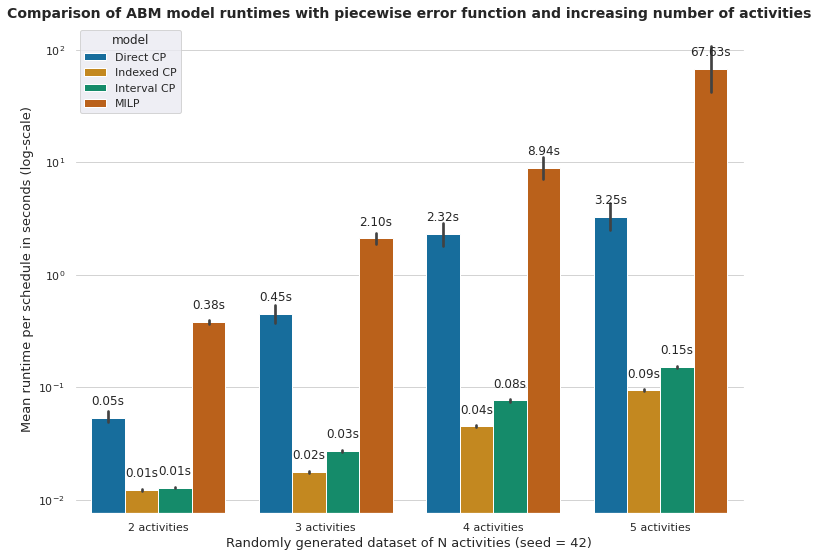

In [13]:
def plot_runtimes_by_model(error_function='piecewise'):

    # Combine all "random_X" into one dataframe
    df = pd.DataFrame(columns=runtimes['random_2'].columns)

    for i, random_runtimes in enumerate(runtimes.values()):
        sub_df = random_runtimes[random_runtimes.error_func == error_function].copy()
        sub_df['dataset'] = f"{i+2} activities"

        sub_df = sub_df.replace({"basic": "Direct CP", "indexed": "Indexed CP", 
                                 "interval": "Interval CP", "milp": "MILP"})

        df = pd.concat([df, sub_df])

    # Plot data by dataset and model type
    sns.set(rc={'figure.figsize':(12, 9)})
    sns.set_palette('colorblind', desat=0.9)

    ax = sns.barplot(x='dataset', y='value', hue='model', data=df, log=True, palette='colorblind')
    ax.set_title(f"Comparison of ABM model runtimes with {error_function} error function and increasing number of activities", fontweight='bold', fontsize=14)
    ax.set_xlabel("Randomly generated dataset of N activities (seed = 42)", fontsize=13)
    ax.set_ylabel("Mean runtime per schedule in seconds (log-scale)", fontsize=13)
    ax.set(facecolor="white")
    ax.grid(c='lightgray', axis='y')

    # Add bar labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2fs", padding=10)

    plt.savefig(DATA_PATH / f"{error_function}_runtimes.png", dpi=300)
    plt.show()

plot_runtimes_by_model("piecewise")

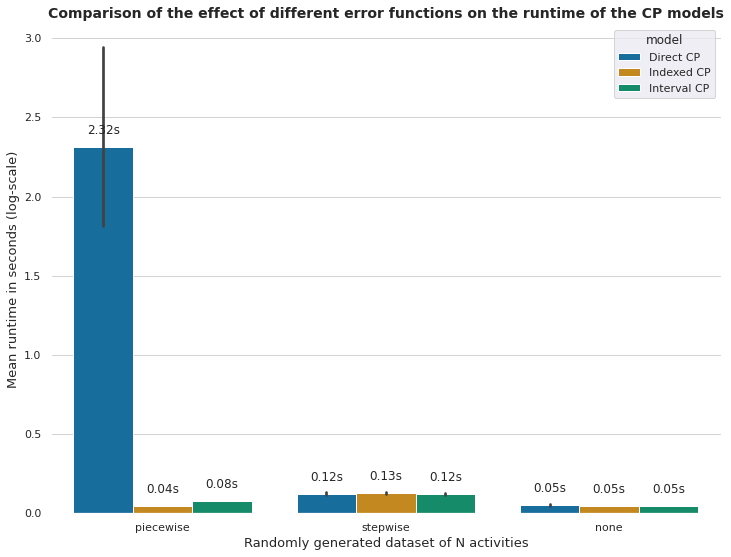

In [14]:
def plot_runtimes_by_errfunc(models=('basic', 'indexed', 'interval')):

    # Combine all "random_X" into one dataframe

    df = runtimes['random_4']
    df = df[df.model.isin(models)].copy()
    df = df.replace({"basic": "Direct CP", "indexed": "Indexed CP",
                     "interval": "Interval CP", "milp": "MILP"})

    # Plot data by dataset and model type
    sns.set(rc={'figure.figsize':(12, 9)})
    sns.set_palette('colorblind', desat=0.9)

    ax = sns.barplot(x='error_func', y='value', hue='model', data=df, log=False, palette='colorblind')
    ax.set_title(f"Comparison of the effect of different error functions on the runtime of the CP models",
                 fontweight='bold', fontsize=14)
    ax.set_xlabel("Randomly generated dataset of N activities", fontsize=13)
    ax.set_ylabel("Mean runtime in seconds (log-scale)", fontsize=13)
    ax.set(facecolor="white")
    ax.grid(c='lightgray', axis='y')


    # Add bar labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2fs", padding=10)

    plt.savefig(DATA_PATH / f"error_func_runtimes.png", dpi=300)
    plt.show()

plot_runtimes_by_errfunc()

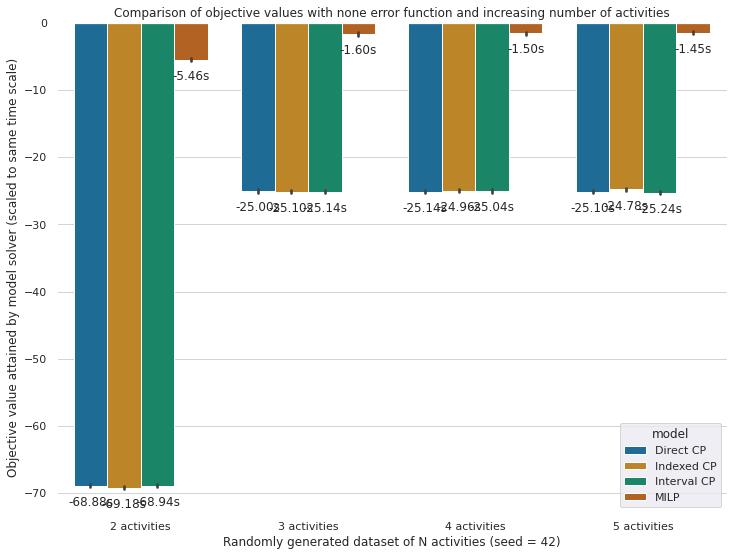

In [3]:
def plot_objectives_by_model(error_function='piecewise'):

    # Combine all "random_X" into one dataframe
    df = pd.DataFrame(columns=objectives['random_2'].columns)

    for i, random_objectives in enumerate(objectives.values()):
        sub_df = random_objectives[random_objectives.error_func == error_function].copy()

        sub_df['dataset'] = f"{i+2} activities"

        sub_df = sub_df.replace({"basic": "Direct CP", "indexed": "Indexed CP",
                                 "interval": "Interval CP", "milp": "MILP"})

        df = pd.concat([df, sub_df])

    # Plot data by dataset and model type
    sns.set(rc={'figure.figsize':(12, 9)})
    sns.set_palette('colorblind', desat=0.9)
    ax = sns.barplot(x='dataset', y='value', hue='model', data=df, log=False)
    ax.set(title=f"Comparison of objective values with {error_function} error function and increasing number of activities",
           facecolor="white",
           ylabel="Objective value attained by model solver (scaled to same time scale)",
           xlabel="Randomly generated dataset of N activities (seed = 42)")
    ax.grid(c='lightgray', axis='y')


    # Add bar labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2fs", padding=10)

    plt.savefig(DATA_PATH / f"{error_function}_objectives.png")
    plt.show()

plot_objectives_by_model('none')

In [7]:
from ortools.sat.python import cp_model

model = cp_model.CpModel()
solver = cp_model.CpSolver()

print(solver.parameters.max_time_in_seconds)

inf
